## Credit Value at Risk Estimation - Using Monto Carlo Simulation

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

### Self-defined functions

In [2]:
# define a function to generate a randint
def RANTBL(pval):
    rdn = np.random.uniform(0,1)
    cumsums = pval.cumsum()
    cumsums = cumsums.T
    class_n = cumsums.size
    class_index = 1
    for i in range(class_n-1):
        if cumsums[i+1] >= rdn and cumsums[i] <= rdn:
            class_index = i+2
            break
    return class_index

In [2]:
from matplotlib import pyplot

#绘制累积曲线
def drawCumulativeHist(heights):
#创建累积曲线
      #第一个参数为待绘制的定量数据
      #第二个参数为划分的区间个数
    #normed参数为是否无量纲化
      #histtype参数为'step'，绘制阶梯状的曲线
    #cumulative参数为是否累积
    pyplot.hist(heights, 20, normed=True, histtype='step', cumulative=True)
    pyplot.xlabel('Heights')
    pyplot.ylabel('Frequency')
    pyplot.title('Heights Of Male Students')
    pyplot.show()

#绘制散点图
def drawScatter(heights, weights):
    #创建散点图
    #第一个参数为点的横坐标
    #第二个参数为点的纵坐标
    pyplot.scatter(heights, weights)
    pyplot.xlabel('Heights')
    pyplot.ylabel('Weights')
    pyplot.title('Heights & Weights Of Male Students')
    pyplot.show()

#绘制直方图
def drawHist(heights):
    #创建直方图
    #第一个参数为待绘制的定量数据，不同于定性数据，这里并没有事先进行频数统计
    #第二个参数为划分的区间个数
    pyplot.hist(heights, 100)
    pyplot.xlabel('Heights')
    pyplot.ylabel('Frequency')
    pyplot.title('Heights Of Male Students')
    pyplot.show()


### Initial parameters
* portfolio weight
* migration matrix
* LIED (the distribution of loss in the event of default)
* LIEDPROB
* historical average default rate
* threshold for 'high-default' year

In [138]:
# Set rating catergory numbers
RATING_N = 7
# supply the parameters of the simulation.
HISTDEFRATE=0.035   # historical average default rate
THRESHOLD=0.06;     # threshold for 'high-default' year

# Set simulation times
SIM_N = 1000
# Set simulation years
YEAR_N = 20

portfolio_weights = np.matrix([1000,1000,1000,0,0,0,0])
portfolio_weights = portfolio_weights.T

# Coupon Rate for different credit
CouponRate = np.matrix([3,3.2,3.4,3.8,4,4.5,
                        3.1,3.3,3.55,4,4.15,4.63,
                        3.2,3.33,3.78,4.11,4.29,4.88,
                        3.55,3.73,4.21,4.61,4.77,5.32,
                        4.01,4.32,4.87,5.39,5.65,6.02,
                        4.66,5.03,5.83,6.29,6.48,6.99,
                        10.02,10.18,9.65,9.31,8.45,8.15])
CouponRate = CouponRate.reshape(7,6)
AvgCoupon = CouponRate.mean(axis=1)/100

# Migration matrix of "normal" years
MIGR_NORMAL = np.matrix([0.9168,0.0761,0.0069,0.0000,0.0002,0.0000,0.0000,0.0000,
                         0.0143,0.9070,0.0746,0.0029,0.0009,0.0001,0.0000,0.0002,
                         0.0007,0.0235,0.9187,0.0502,0.0055,0.0012,0.0001,0.0001,
                         0.0004,0.0026,0.0568,0.8786,0.0515,0.0077,0.0008,0.0014,
                         0.0002,0.0005,0.0049,0.0547,0.8581,0.0655,0.0042,0.0119,
                         0.0001,0.0003,0.0013,0.0046,0.0693,0.8398,0.0209,0.0637,
                         0.0000,0.0000,0.0000,0.0071,0.0218,0.0450,0.6740,0.2520])
MIGR_NORMAL = MIGR_NORMAL.reshape(7,8)

# Migration matrix of "high-default" years
MIGR_HIGH = np.matrix([0.9100,0.0600,0.0275,0.0025,0.0000,0.0000,0.0000,0.0000,
                       0.0045,0.8453,0.1206,0.0132,0.0082,0.0032,0.0030,0.0020,
                       0.0000,0.0051,0.8892,0.0736,0.0094,0.0057,0.0120,0.0050,
                       0.0000,0.0061,0.0377,0.8439,0.0512,0.0161,0.0350,0.0100,
                       0.0000,0.0000,0.0066,0.0351,0.8387,0.0855,0.0066,0.0275,
                       0.0000,0.0000,0.0000,0.0010,0.0400,0.8400,0.0133,0.1057,
                       0.0000,0.0000,0.0000,0.0100,0.0200,0.1250,0.4700,0.3750])
MIGR_HIGH = MIGR_HIGH.reshape(7,8)

# Define the distribution of loss in the event of default (LIED)
LIED = np.matrix([0.0125,0.05,0.10,0.15,0.20,0.25,0.30,
                  0.35,0.40,0.45,0.50,0.55,0.60,0.65,
                  0.70,0.75,0.80,0.85,0.90,0.95,0.9875])
LIED = LIED.T

# array 'LIEDPROB' provides the probabilities
LIEDPROB = np.matrix([0.1237,0.1410,0.1069,0.0708,0.0450,0.0394,
                      0.0427,0.0405,0.0450,0.0247,0.0225,0.0337,0.0259,
                      0.0326,0.0281,0.0225,0.0247,0.0236,0.0225,0.0236,0.0606])
LIEDPROB = LIEDPROB.T

# risk-free rate
rf = 0.032

### Simulation
* main loop
    * Inner Loop:20 Years
        * Inner Loop:Rating Categories
            * Inner Loop: Each dollar Exposure

In [ ]:
LOSS_set = [] # LOSS value every simulaition
RF_LOSS_set = [] # LOSS after risk-free adjustment
NET_LOSS_set = [] # LOSS after risk-free and coupon adjustment
HIGHDEFYEAR_set = [] # HIGHDEFYEAR every simulation
for SIM in range(SIM_N):
    if SIM%10 == 0:
        print SIM
    # start with the input portfolio, move it into the current portfolio.
    CURPORTF = portfolio_weights
    # variable 'LOSS' summarizes the losses, set it to zero initially.
    LOSS = 0
    RF_LOSS = 0
    NET_LOSS = 0
    # variable 'HIGHDEFYEAR' keeps track of the number of years with high default rate.
    HIGHDEFYEAR=0
    
    # migrate the portfolio through YEAR_N.
    for YEAR in range(YEAR_N):
        # array 'NEWPORT' has the current portfolio after each annual
        # migration. Set it to zero before each yearly migration, and
        # then collect the exposures by the risk categories to which hey migrate.
        NEWPORTF = np.matrix([0,0,0,0,0,0,0])
        NEWPORTF = NEWPORTF.T
        
        # determine the type of year, i.e. 'Normal' (REGIME=1) or 'High-default' (REGIME=2).
        MACROECO = 1.0*np.random.binomial(100,HISTDEFRATE)/100
        if MACROECO > THRESHOLD:
            REGIME = 2
            HIGHDEFYEAR += 1
        else:
            REGIME = 1
            
        # take one risk category of the portfolio.
        for RATING in range(RATING_N):
            # load the migration percentages of the given year-type and
            # rating into a temporary array to be used for each dollar of the current rating category.
            if REGIME == 1:
                PROB = MIGR_NORMAL[RATING]
            else:
                PROB = MIGR_HIGH[RATING] ### 这里有问题？？？ 源代码为什么不加default这一列的数据
            
            # go through every exposure of a given rating category.
            for P in range(1,CURPORTF[RATING]+1):
                # take a random draw from the migration probabilities 
                # to determine the new risk category of the exposure.
                NEWRATING=RANTBL(PROB)
                
                # if the exposure migrates to risk category '8', it goes
                # into default. Draw a random loss-value from the      
                # empirical loss distribution. If the migration does     
                # not result in default, assign the exposure to the new risk category.
                if NEWRATING == 8:
                    LOSS += LIED[RANTBL(LIEDPROB)-1]
                    RF_LOSS += (LIED[RANTBL(LIEDPROB)-1])*(np.exp(-rf*YEAR))
                else:
                    NEWPORTF[NEWRATING-1] += 1
        
        NET_LOSS = RF_LOSS-(NEWPORTF.T)*AvgCoupon*(np.exp(-rf*YEAR)) #NET_LOSS
        # make the new portfolio the current one, so the 
        # next annual migration can be performed.
        CURPORTF = NEWPORTF
    if LOSS != 0:
        LOSS = LOSS[0,0]
    if RF_LOSS != 0:
        RF_LOSS = RF_LOSS[0,0]
    if NET_LOSS != 0:
        NET_LOSS = NET_LOSS[0,0]
    LOSS_set.append(LOSS)
    RF_LOSS_set.append(RF_LOSS)
    NET_LOSS_set.append(NET_LOSS)
    HIGHDEFYEAR_set.append(HIGHDEFYEAR)

In [143]:
result = {'LOSS_set':LOSS_set,
         'RF_LOSS_set':RF_LOSS_set,
         'NET_LOSS_set':NET_LOSS_set,
         'HIGHDEFYEAR_set':HIGHDEFYEAR_set}
result_df = pd.DataFrame(result)
result_df.to_excel('result.xlsx')

### Read the result

In [24]:
result_df = pd.read_excel('result.xlsx')
highD_df = result_df['HIGHDEFYEAR_set']
LOSS_df = result_df['LOSS_set']
RF_LOSS_df = result_df['RF_LOSS_set']
NET_LOSS_df = result_df['NET_LOSS_set']
two_df = result_df[['LOSS_set','RF_LOSS_set']]
two2_df = result_df[['RF_LOSS_set','NET_LOSS_set']]
three_df = result_df[['LOSS_set','RF_LOSS_set','NET_LOSS_set']]

### VaR
* 95% VaR
* 99% VaR

In [141]:
VaR_95 = three_df.quantile(0.95)
VaR_99 = three_df.quantile(0.99)
print VaR_95
print VaR_99

LOSS_set        81.093750
RF_LOSS_set     54.657727
NET_LOSS_set    -8.621673
Name: 0.95, dtype: float64
LOSS_set        96.768250
RF_LOSS_set     65.611836
NET_LOSS_set     2.737761
Name: 0.99, dtype: float64


## Result

### The Distribution of the number of High-default years in 20 years

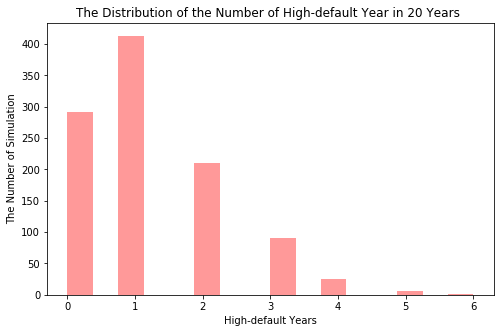

In [117]:
fig = plt.figure(figsize=(8,5))
sns.distplot(highD_df,kde=False,hist=True,color='r')
plt.title('The Distribution of the Number of High-default Year in 20 Years ')
plt.ylabel('The Number of Simulation')
plt.xlabel('High-default Years')
plt.show()

### LOSS_set

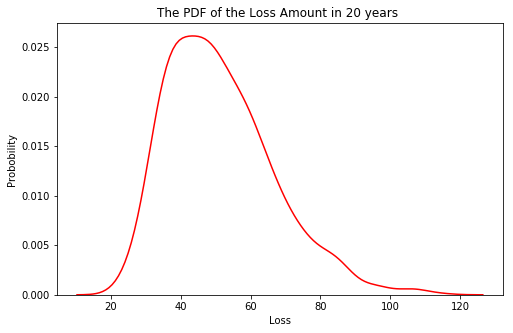

In [118]:
fig = plt.figure(figsize=(8,5))
sns.distplot(LOSS_df,kde=True,hist = False,color='r')

plt.title('The PDF of the Loss Amount in 20 years ')
plt.ylabel('Probobility')
plt.xlabel('Loss')
plt.show()

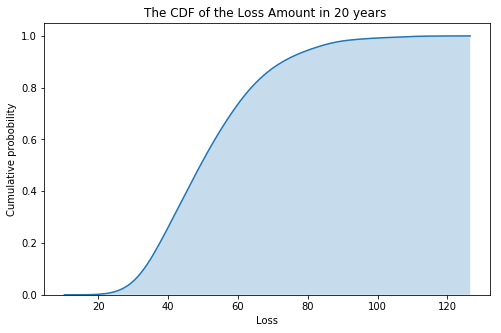

In [119]:
fig = plt.figure(figsize=(8,5))
sns.kdeplot(LOSS_df,cumulative=True,shade=True,legend=False)
plt.title('The CDF of the Loss Amount in 20 years ')
plt.ylabel('Cumulative probobility')
plt.xlabel('Loss')
plt.show()

### RF_LOSS_set

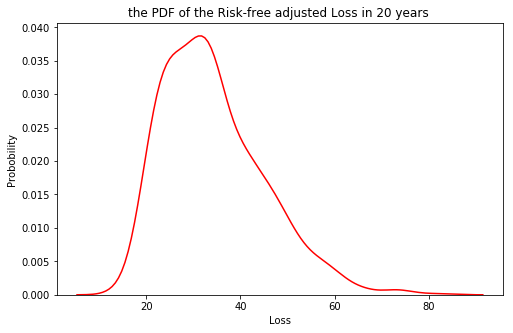

In [120]:
fig = plt.figure(figsize=(8,5))
sns.distplot(RF_LOSS_df,kde=True,hist = False,color='r')
plt.title('the PDF of the Risk-free adjusted Loss in 20 years ')
plt.ylabel('Probobility')
plt.xlabel('Loss')
plt.show()

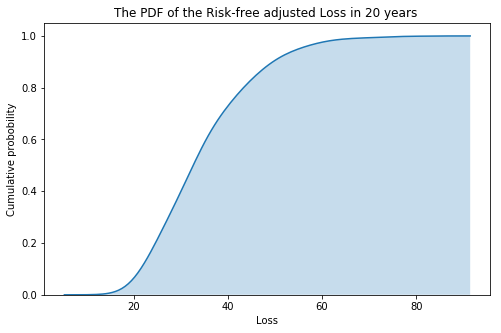

In [121]:
fig = plt.figure(figsize=(8,5))
sns.kdeplot(RF_LOSS_df,cumulative=True,shade=True,legend=False)
plt.title('The PDF of the Risk-free adjusted Loss in 20 years ')
plt.ylabel('Cumulative probobility')
plt.xlabel('Loss')
plt.show()

### LOSS and RF-LOSS 

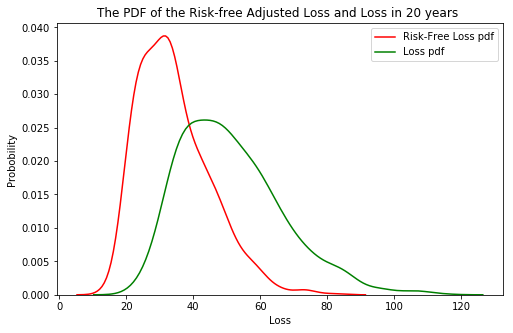

In [123]:
fig = plt.figure(figsize=(8,5))
sns.distplot(RF_LOSS_df,kde=True,hist = False,color='r',label='Risk-Free Loss pdf')
sns.distplot(LOSS_df,kde = True,hist = False,color='g',label='Loss pdf')
plt.title('The PDF of the Risk-free Adjusted Loss and Loss in 20 years ')
plt.ylabel('Probobility')
plt.xlabel('Loss')
plt.show()

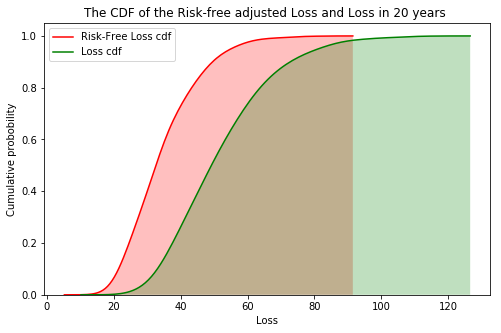

In [126]:
fig = plt.figure(figsize=(8,5))
sns.kdeplot(RF_LOSS_df,cumulative=True,shade=True,color='r',label='Risk-Free Loss cdf')
sns.kdeplot(LOSS_df,cumulative=True,shade=True,color='g',label='Loss cdf')
plt.title('The CDF of the Risk-free adjusted Loss and Loss in 20 years ')
plt.ylabel('Cumulative probobility')
plt.xlabel('Loss')
plt.show()

### RF-Loss and NET_LOSS

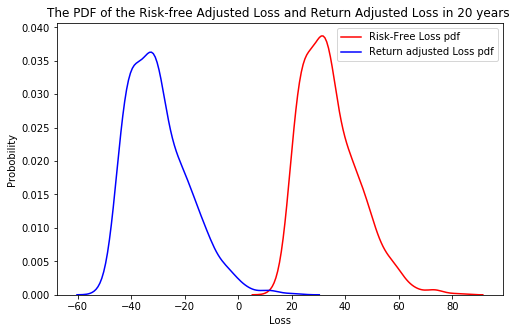

In [127]:
fig = plt.figure(figsize=(8,5))
sns.distplot(RF_LOSS_df,kde=True,hist = False,color='r',label='Risk-Free Loss pdf')
sns.distplot(NET_LOSS_df,kde = True,hist = False,color='b',label='Return adjusted Loss pdf')
plt.title('The PDF of the Risk-free Adjusted Loss and Return Adjusted Loss in 20 years ')
plt.ylabel('Probobility')
plt.xlabel('Loss')
plt.show()

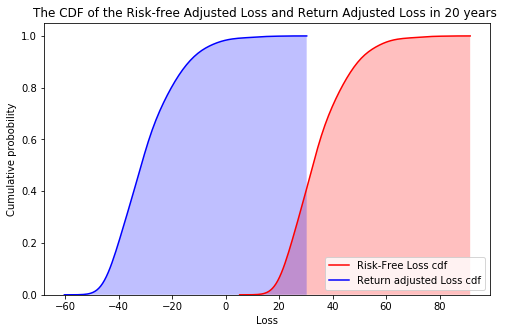

In [128]:
fig = plt.figure(figsize=(8,5))
sns.kdeplot(RF_LOSS_df,cumulative=True,shade=True,color='r',label='Risk-Free Loss cdf')
sns.kdeplot(NET_LOSS_df,cumulative=True,shade=True,color='b',label='Return adjusted Loss cdf')
plt.title('The CDF of the Risk-free Adjusted Loss and Return Adjusted Loss in 20 years ')
plt.ylabel('Cumulative probobility')
plt.xlabel('Loss')
plt.show()

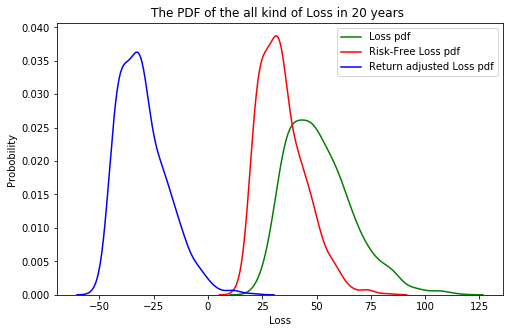

In [129]:
fig = plt.figure(figsize=(8,5))
sns.distplot(LOSS_df,kde=True,hist = False,color='g',label='Loss pdf')
sns.distplot(RF_LOSS_df,kde=True,hist = False,color='r',label='Risk-Free Loss pdf')
sns.distplot(NET_LOSS_df,kde = True,hist = False,color='b',label='Return adjusted Loss pdf')
plt.title('The PDF of the all kind of Loss in 20 years ')
plt.ylabel('Probobility')
plt.xlabel('Loss')
plt.show()

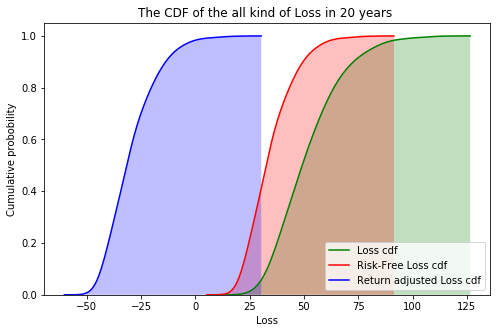

In [132]:
fig = plt.figure(figsize=(8,5))
sns.kdeplot(LOSS_df,cumulative=True,shade=True,color='g',label='Loss cdf')
sns.kdeplot(RF_LOSS_df,cumulative=True,shade=True,color='r',label='Risk-Free Loss cdf')
sns.kdeplot(NET_LOSS_df,cumulative=True,shade=True,color='b',label='Return adjusted Loss cdf')
plt.title('The CDF of the all kind of Loss in 20 years ')
plt.ylabel('Cumulative probobility')
plt.xlabel('Loss')
plt.show()